In [29]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV
import re

In [30]:
# Step 2: Load and Preprocess Data
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'rt', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load dataset
url= "https://raw.githubusercontent.com/anelson911/Hate-Speech-Demo-Final-Project/refs/heads/main/labeled_data.csv"
df = pd.read_csv(url)
df['processed_tweet'] = df['tweet'].apply(preprocess_text)
df['binary_label'] = (df['class'] != 2).astype(int)

In [31]:
# Step 3: Split Data
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_tweet'], 
    df['binary_label'],
    test_size=0.2,
    random_state=42,
    stratify=df['binary_label']
)   

In [32]:
# Step 4: Vectorize Text
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [33]:
# Step 5: Train Model
base_clf = LogisticRegression(class_weight='balanced')
calibrated_clf = CalibratedClassifierCV(base_clf, cv=5)
calibrated_clf.fit(X_train_tfidf, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(class_weight='balanced'))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       833
           1       0.96      0.97      0.97      4124

    accuracy                           0.94      4957
   macro avg       0.90      0.90      0.90      4957
weighted avg       0.94      0.94      0.94      4957



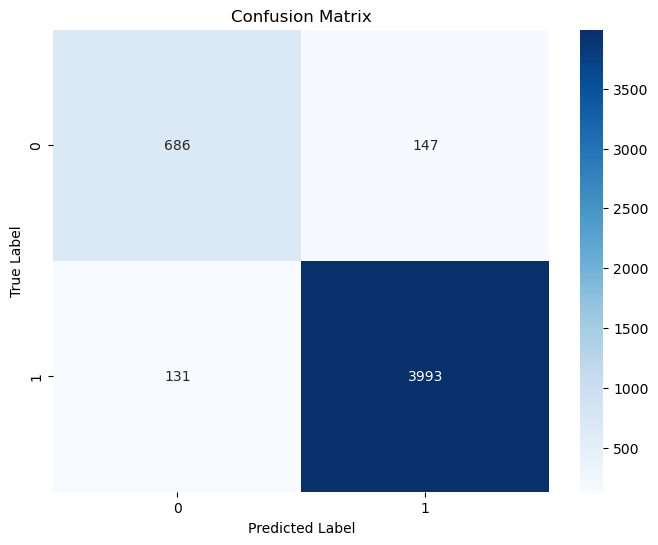

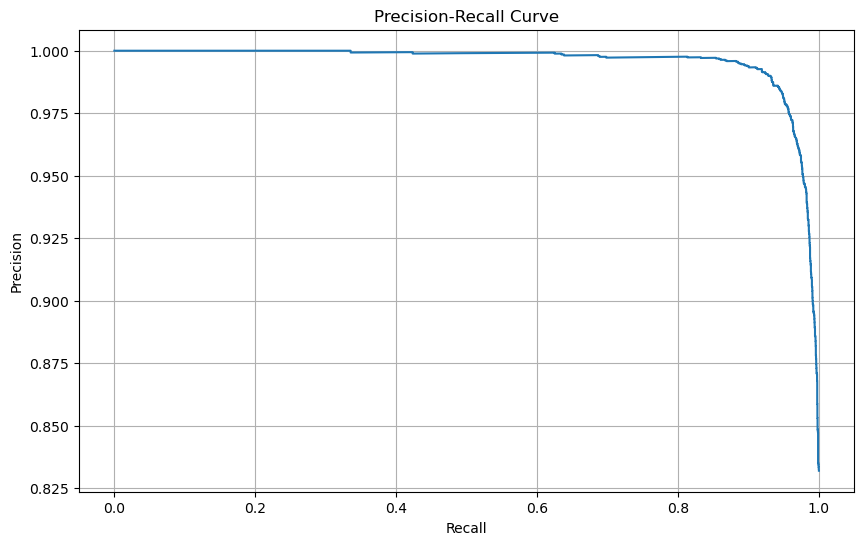

In [34]:
# Step 6: Evaluate Model
y_pred = calibrated_clf.predict(X_test_tfidf)
y_pred_proba = calibrated_clf.predict_proba(X_test_tfidf)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [35]:
# Step 7: Inference Function
def predict_threat(text):
    processed = preprocess_text(text)
    tfidf_vector = tfidf.transform([processed])
    probability = calibrated_clf.predict_proba(tfidf_vector)[0]
    prediction = calibrated_clf.predict(tfidf_vector)[0]
    return {
        'text': text,
        'processed_text': processed,
        'prediction': 'Potential Threat' if prediction == 1 else 'No Threat',
        'confidence': probability[1]
    }

# Test the prediction function
test_texts = [
    "I love this beautiful day!",
    "I will hurt you and your family",
    "Having a great time with friends",
    "You better watch your back or else",
    "I am going to hurt you you faggot",
    "Faggots should die",
    "Had fun at the fall festival"
]

for text in test_texts:
    result = predict_threat(text)
    print(f"\nText: {result['text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2f}")


Text: I love this beautiful day!
Prediction: No Threat
Confidence: 0.38

Text: I will hurt you and your family
Prediction: Potential Threat
Confidence: 0.62

Text: Having a great time with friends
Prediction: No Threat
Confidence: 0.25

Text: You better watch your back or else
Prediction: Potential Threat
Confidence: 0.57

Text: I am going to hurt you you faggot
Prediction: Potential Threat
Confidence: 1.00

Text: Faggots should die
Prediction: Potential Threat
Confidence: 0.98

Text: Had fun at the fall festival
Prediction: No Threat
Confidence: 0.30


In [36]:
# Step 8: Add User Input
def get_user_input():
    user_text = input("Enter text to analyze: ")
    return user_text

# Analyze user input
user_input = get_user_input()
user_result = predict_threat(user_input)
print(f"\nUser Text: {user_result['text']}")
print(f"Prediction: {user_result['prediction']}")
print(f"Confidence: {user_result['confidence']:.2f}")


User Text: i am going to plant a bomb in the police chiefs car.
Prediction: No Threat
Confidence: 0.38
